In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Colormap for time
import re
import scienceplots
plt.style.use(['science','nature','no-latex','vibrant'])

from scipy.signal import find_peaks, butter, filtfilt



#Import personal functions
import sys
#sys.path.append("C:/Users/Olivi/OneDrive - TU Eindhoven/Soft robotic matter/GitHub/Thermal_Soft_Robotics/Functions")
sys.path.append("//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Functions")
import FluidicSetupFunctions
from save_plot_func import save_plot


In [54]:
#Location = r"C:\Users\Olivi\OneDrive - TU Eindhoven\Soft robotic matter\data_analysis"
Location = r"//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Thermal_actuation/Experimental/Fluidic/Actuators"
Foldernames = ["/Data/width_sweep"]

data = FluidicSetupFunctions.LoadData(Foldernames = Foldernames,Location=Location)

print(data[0][-1].head)


Loading... Folder 1 of 1, Sample 1 of 5
Loading... Folder 1 of 1, Sample 2 of 5
Loading... Folder 1 of 1, Sample 3 of 5
Loading... Folder 1 of 1, Sample 4 of 5
Loading... Folder 1 of 1, Sample 5 of 5
<bound method NDFrame.head of         flowFesto-1  DigOut-1   SSCDP30-9     Time
0          0.000037       0.0   50.559083    0.001
1         -0.000010       0.0   40.280822    0.002
2         -0.000120       0.0   31.262755    0.003
3         -0.000281       0.0   23.466631    0.004
4         -0.000481       0.0   16.854201    0.005
...             ...       ...         ...      ...
211295     0.001067       0.0  230.873302  211.296
211296     0.001259       0.0  234.478685  211.297
211297     0.001422       0.0  237.512370  211.298
211298     0.001553       0.0  239.694656  211.299
211299     0.001645       0.0  240.745842  211.300

[211300 rows x 4 columns]>


In [51]:
#Extract names for plotting
items = data[1]['Samplename']
print(items[0].split('w'))

# Use regular expression to match 'w' followed by any number of digits
Sample_names = [re.match(r'w(\d+)_', item).group(1) if re.match(r'(w\d+)_', item) else item for item in items]

print(Sample_names)

['2_', '2_1']
['2_w2_1', '4_w4_1', '6_w8_1', '1_w16_1', '0_w32_1']


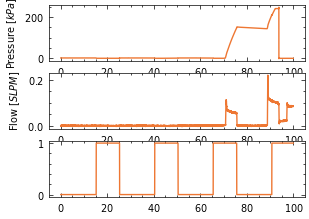

In [3]:
P = data[0][0]['SSCDP30-9']/1000
t = data[0][0]['Time']
Q = data[0][0]['flowFesto-1']
digout = data[0][0]['DigOut-1']


ax1=plt.subplot(311)
plt.plot(t,P)

plt.ylabel('Pressure [$kPa$]')

ax2 = plt.subplot(312,sharex=ax1)
plt.plot(t,Q)
plt.xlabel('Time[$s$]')
plt.ylabel('Flow [$SLPM$]')


ax3 = plt.subplot(313,sharex=ax1)
plt.plot(t,digout)

plt.show()

Prepare data: slice per run

In [57]:
# Slice data per run 
data_sliced = []
for index,value in enumerate(data[0]):
    runs = [] # new list for all the runs in data[0]
    start = 0
    run_count = 1  # Counter for run number

    df = data[0][index]
    print(index)

    P = data[0][index]['SSCDP30-9']
    t = data[0][index]['Time']
    Q = data[0][index]['flowFesto-1']
    dig_out = data[0][index]['DigOut-1']  
   

    while start < len(data[0][index]['DigOut-1']):
        # Find the next '1' in 'DigOut-1' starting from 'start'.
        next_ones = np.where(dig_out[start:] == 1)[0]
        if next_ones.size == 0:  # If there are no more '1's, exit the loop.
            break
        start += next_ones[0]  # Adjust 'start' to the new index.

        # Find the next '0' in 'DigOut-1' starting from the new 'start'.
        next_zeros = np.where(dig_out[start:] == 0)[0]
        if next_zeros.size == 0:  # If there are no '0's following the '1's, take the rest of the array.
            end = len(dig_out)
        else:
            end = start + next_zeros[0]  # Adjust 'end' to the new index.
        
        
      
        # Create a DataFrame for this run
        run_df = pd.DataFrame({
            'Time': t[start:end]-t[start], 
            'Flow': Q[start:end],
            'Pressure': P[start:end]/1000   
        })

        # Append this DataFrame to the list
        runs.append(run_df)   

        start = end + 5  # Move to next segment
        run_count += 1  # Increment run counter

   
    data_sliced.append(runs)
   



0
1
2
3
4


In [39]:
# Butterworth filter design
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function for moving average smoothing
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')




1050


104.02219140083218

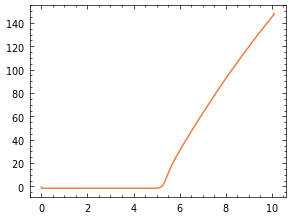

In [8]:
len(data_sliced[0])
data_sliced[0][0]
plt.plot(data_sliced[0][-1]["Time"],data_sliced[0][-1]["Pressure"])
np.mean(data_sliced[0][-1]["Flow"])

peaks,_ = find_peaks(data_sliced[0][-1]["Pressure"])
n_peaks=len(peaks)
print(n_peaks)
len(data_sliced[0][-1]["Time"]/1000)
measurement_t = len(data_sliced[0][-1]["Time"])/1000
f = n_peaks/measurement_t 
f

[-0.0, -0.0, 0.03, 0.07]
[0.0, 0.0, 0.09906875371507827, 6.502655250894115]
[-0.0, -0.0, 0.0, 0.06, 0.41, 0.91]
[0.0, 0.0, 0.0, 2.890749601275917, 30.674235633901006, 20.066889632107024]
[-0.0, -0.0, 0.02, 0.08, 0.43, 0.93, 1.92, 2.93]
[0.0, 0.0, 0.49810719266786213, 2.189708370657908, 4.476721050537207, 6.25, 8.667928663943409, 18.333997608609007]
[-0.0, -0.0, 0.0, 0.06, 0.4, 0.91, 1.9]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.09976057462090983, 0.0]
[-0.0, -0.0, 0.0, 0.05, 0.4, 0.91, 1.9, 2.9]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


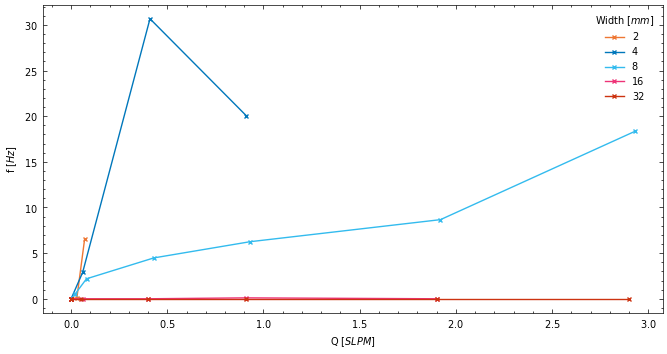

In [59]:
# Define sampling rate and cutoff frequency
fs = 1000  # example sampling rate
cutoff = 150  # cutoff frequency in Hz for low-pass filter

# Window size for smoothing
window_size = 100 

plt.figure(figsize=(8, 4))

Q_mean = []
f=[]
results = []
sample_names=[2,4,8,16,32]

for index, runs_data in enumerate(data_sliced):
    Q_mean = []
    f=[]
    for i,run_data in enumerate(runs_data):
        #print(i,run_data)
        time = run_data["Time"]
        P_raw = run_data["Pressure"]
        
        
        # Filter the signal
        filtered_pressure = butter_lowpass_filter(P_raw, cutoff, fs)
        P = moving_average(filtered_pressure,window_size)

        # Find peaks with dynamic thresholding and minimum distance
        peaks, _ = find_peaks(P,height=40)
        n_peaks = len(peaks)

    
        measurement_t = len(run_data["Time"])/1000
        f.append(n_peaks/measurement_t )


    # Correct usage of np.round and np.mean for labeling
        mean_flow = np.round(np.mean(run_data["Flow"]), 2)
        Q_mean.append(mean_flow)

    # zip and store results 
    results.append(zip(f,Q_mean))
    print(Q_mean)
    print(f)
   
    plt.plot(Q_mean,f,label=sample_names[index],marker='x')

plt.xlabel("Q [$SLPM$]")
plt.ylabel("f [$Hz$]")
plt.legend(title='Width [$mm$]')
plt.show()



Extract opening and closing pressure

Results